In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as linmod
import math
import scipy.stats as stats

# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('./data/fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = './data/fishing.npz')
d = np.load('./data/fishing.npz')
Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


### a)

In [4]:
intercept = np.ones((Xt.shape[0], 1))
Xti = np.append(Xt, intercept, axis=1)
pd.DataFrame(Xti)

,0,1,2,3,4
0,1.0,0.0,4.0,0.0,1.0
1,1.0,1.0,2.0,0.0,1.0
2,1.0,1.0,3.0,0.0,1.0
3,1.0,1.0,3.0,2.0,1.0
4,1.0,1.0,4.0,1.0,1.0
...,...,...,...,...,...
195,1.0,1.0,1.0,0.0,1.0
196,1.0,1.0,1.0,0.0,1.0
197,1.0,1.0,3.0,0.0,1.0
198,1.0,0.0,1.0,0.0,1.0


In [5]:
coeffs = np.linalg.inv(Xti.T @ Xti) @ Xti.T @ yt
coeffs

array([ 2.4822138 ,  2.95430727,  4.64953914, -5.47160051, -8.49222821])

### b)

In [6]:
reg = linmod.LinearRegression().fit(Xt, yt)
reg.coef_

array([ 2.4822128,  2.9543095,  4.6495404, -5.4716005], dtype=float32)

### c)

In [7]:
intercept = np.ones((Xte.shape[0], 1))
Xtei = np.append(Xte, intercept, axis=1)
y_hat = Xtei @ coeffs
e = (yte - y_hat)
se = e**2
rmse = math.sqrt(sum(se) / Xte.shape[0])
rmse

8.588126386734231

In [8]:
sigma = np.var(e)
sigma

73.4803035991981

In [9]:
ll =  0
for i, y in enumerate(y_hat):
    ll += math.log((1 / math.sqrt(2 * math.pi * sigma)) * math.exp(-((y - yte[i])**2 / (2 * sigma))))

-ll / y_hat.shape[0]

3.569322638168201

### d)

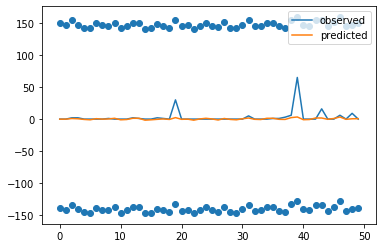

In [67]:
qx = []
qy = []
for i, y in enumerate(y_hat):
    qx.append(i)
    qy.append(coeffs @ Xtei[i] + 1.96 * sigma)
    qx.append(i)
    qy.append(coeffs @ Xtei[i] - 1.96 * sigma)

plt.plot(yte, label="observed")
plt.plot(y_hat, label="predicted")
plt.scatter(qx, qy)
plt.legend()

### e)

In [11]:
beta = np.array([1, 1, 1, 1, 1])
nll = 0
for i, x in enumerate(Xti):
    nll += math.exp(beta @ x) - yt[i] * beta @ x + math.log(math.factorial(yt[i]))
    
nll / Xti.shape[0]

1507.9856602262093

In [20]:
grad  = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
for i, g in enumerate(grad):
    for j, x in enumerate(Xti):
        grad[i] += x[i] * math.exp(beta @ x) - yt[j] * x[i]
    grad[i] /= Xti.shape[0]

grad

array([1403.99474131, 1171.02247951, 5701.91224653, 3258.70389229,
       1518.61304305])

In [31]:
def calc_gradient(i, beta):
    grad = 0
    for j, x in enumerate(Xti):
        grad += x[i] * math.exp(beta @ x) - yt[j] * x[i]
    return grad

beta = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
buff = beta
for i in range(5000):
    for j, b in enumerate(buff):
        buff[j] = beta[j] - 0.001 * calc_gradient(j, beta)
    beta = buff

beta
#array([ 0.29016716,  0.57629665,  0.87001082, -1.60306712, -1.20346077])

array([ 1.64576584,  0.76326005,  1.02617452, -1.60140756, -3.20227429])

In [36]:
y_hat = Xtei @ beta
e = (yte - y_hat)
se = e**2
rmse = math.sqrt(sum(se) / Xte.shape[0])
rmse

9.933883664867972

In [59]:
ll =  0
for i, y in enumerate(yte):
    ll += math.exp(beta @ x) - y * beta @ x + math.log(math.factorial(y))

-ll / y_hat.shape[0]

-9.522487733056687

### f)

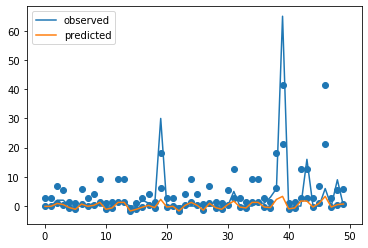

In [70]:
qx = []
qy = []
for i, y in enumerate(y_hat):
    qx.append(i)
    qy.append(stats.poisson.ppf(0.025, math.exp(beta @ Xtei[i]), y))
    qx.append(i)
    qy.append(stats.poisson.ppf(0.975, math.exp(beta @ Xtei[i]), y))

plt.plot(yte, label="observed")
plt.plot(y_hat, label="predicted")
plt.scatter(qx, qy)
plt.legend()